In [263]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import custom_utils

In [264]:
import json
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd

def gather_dataset(folder_path : str) -> dict:
    dataset = dict()
    for item in Path(folder_path).iterdir():
        if not item.is_file(): continue 
        if not item.suffix == ".json": continue

        dialog_id = item.stem
        with open(item, "r") as json_file:
            data = json.load(json_file)
            dialog = []
            for sentence in data:
                dialog.append(sentence["speaker"] + ": " + sentence["text"])
            dataset[dialog_id] = dialog 
    return dataset

def tt_split(dialogs, labels, test_size=0.2, random_state=42):
    train_sentences = []
    val_sentences = []
    train_labels = [] 
    val_labels = []
    for dialog_id in dialogs:
        # train test split inside the dialog
        d_sentences = dialogs[dialog_id]
        d_labels = labels[dialog_id]
        d_train_sentences, d_val_sentences, d_train_labels, d_val_labels = train_test_split(d_sentences, d_labels, test_size=test_size, random_state=random_state)
        
        # aggregate split
        train_sentences += d_train_sentences
        val_sentences += d_val_sentences
        train_labels += d_train_labels
        val_labels += d_val_labels
    
    return train_sentences, val_sentences, train_labels, val_labels


In [265]:
dataset = gather_dataset("training")
with open ('training_labels.json', 'r') as json_file:
    labels = json.load(json_file)

In [266]:
df = tt_split(dataset, labels)
train_sentences, val_sentences, train_labels, val_labels = df
df = pd.DataFrame({'phrase' : train_sentences, 'label' : train_labels})
df

,phrase,label
0,UI: and you could just click that to <disfmarker>,0
1,PM: And uh I I think our discussion was around...,1
2,"ID: Uh y the fewer buttons you have , I guess ...",1
3,PM: and find difficult to learn .,0
4,UI: You know what I mean ?,0
...,...,...
58054,PM: You have to reach a little bit don't you .,0
58055,PM: Mm there's a risk of that .,0
58056,PM: Okay,0
58057,"PM: <vocalsound> Nah , I'm I'm not convinced o...",0


In [223]:
# Selecting the datasets of each class
df_zero = df.loc[df['label'] == 0]
df_one = df.loc[df['label'] == 1]

In [224]:
df_one_word = df_one.copy()
df_one_word['phrase'] = df_one_word['phrase'].apply(lambda x : x.split(' '))
df_one_word = df_one_word.explode(column = 'phrase')

df_zero_word = df_zero.copy()
df_zero_word['phrase'] = df_zero_word['phrase'].apply(lambda x : x.split(' '))
df_zero_word = df_zero_word.explode(column = 'phrase')

In [225]:
df_frequency_one = df_one_word.value_counts().droplevel(1)
df_frequency_zero = df_zero_word.value_counts().droplevel(1)

In [270]:
important_words = set((df_frequency_one / (df_frequency_one + df_frequency_zero)).sort_values(ascending=False).dropna().head(1250).index.to_list())

In [271]:
important_words

{'discussions',
 'automatic',
 'production',
 'hunch',
 'minimise',
 'relatively',
 'trainable',
 'generic',
 'fro',
 'on-off',
 'appears',
 'instruction',
 'First',
 'square',
 'curved',
 'sometimes',
 'stalk',
 'being',
 'fail',
 'thus',
 'complicate',
 'beam',
 'properly',
 'substantial',
 'gap',
 'trend',
 'interf',
 'targeting',
 'shaped',
 'absolute',
 'effect',
 'logos',
 'preference',
 'immediate',
 'physically',
 'between',
 'methods',
 'graphics',
 'flip-open',
 'fast-forward',
 'form',
 'personal',
 'Cat',
 'standards',
 'meets',
 'signals',
 'investigation',
 'wheels',
 'monitor',
 'during',
 'lighted',
 'elaborate',
 'ends',
 'requires',
 'corporate',
 'protection',
 'dial',
 'User-friendly',
 "user's",
 'superfluous',
 'stylish',
 'complete',
 'fancier',
 'casing',
 'eliminate',
 'motto',
 'covers',
 'local',
 'runs',
 'programmable',
 'problematic',
 'designs',
 'dollars',
 'besides',
 'prints',
 'concrete',
 'LEDs',
 'environmentally',
 'strip',
 'sleeve',
 'shoes',
 'p

## Testing frequency approach

In [267]:
def has_word_from_set(phrase, word_set):
    words = phrase.split()
    for word in words:
        if word in word_set:
            return True
    return False

In [268]:
df_frequency = tt_split(dataset, labels)
train_sentences, val_sentences, train_labels, val_labels = df_frequency
df_frequency = pd.DataFrame({'phrase' : train_sentences, 'label' : train_labels})
df_frequency

,phrase,label
0,UI: and you could just click that to <disfmarker>,0
1,PM: And uh I I think our discussion was around...,1
2,"ID: Uh y the fewer buttons you have , I guess ...",1
3,PM: and find difficult to learn .,0
4,UI: You know what I mean ?,0
...,...,...
58054,PM: You have to reach a little bit don't you .,0
58055,PM: Mm there's a risk of that .,0
58056,PM: Okay,0
58057,"PM: <vocalsound> Nah , I'm I'm not convinced o...",0


In [269]:
df_frequency['phrase'] = df_frequency['phrase'].apply(lambda x : has_word_from_set(x, important_words)).astype(int)

In [188]:
f1_score(df_frequency['label'], df_frequency['phrase'])

0.11584776303067593

### Evolution of f1_score

In [198]:
number_of_words = [nwords for nwords in range(100, 4000, 50)]
f1_scores = [0] * len(number_of_words)

for idx, nwords in enumerate(number_of_words):
    important_words = set((df_frequency_one / (df_frequency_one + df_frequency_zero)).sort_values(ascending=False).dropna().head(nwords).index.to_list())
    df_curr = df_frequency.copy()
    
    df_curr['phrase'] = df_curr['phrase'].apply(lambda x : has_word_from_set(x, important_words)).astype(int)
    f1_scores[idx] = (f1_score(df_curr['label'], df_curr['phrase']))

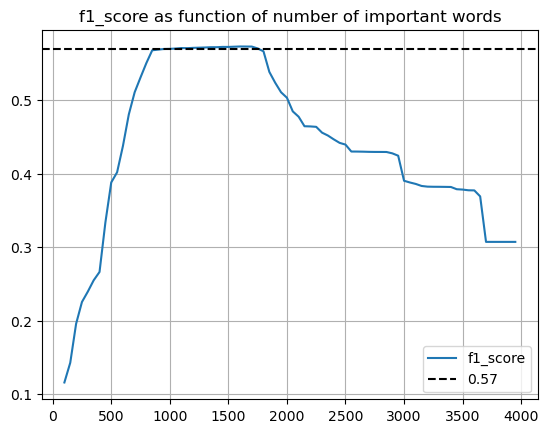

In [221]:
plt.plot(number_of_words, f1_scores, label = 'f1_score')
plt.grid()
plt.axhline(0.57, linestyle = '--', label = '0.57', color = 'black')
plt.legend()
plt.title('f1_score as function of number of important words')
plt.show()

In [228]:
def has_n_words_from_set(phrase, word_set, n):
    words = phrase.split()
    counter = 0
    for word in words:
        if word in word_set:
            counter += 1
            if counter == n:
                return True
    return False

In [241]:
number_of_words = [nwords for nwords in range(100, 4000, 50)]
f1_scores = [0] * len(number_of_words)

for idx, nwords in enumerate(number_of_words):
    important_words = set((df_frequency_one / (df_frequency_one + df_frequency_zero)).sort_values(ascending=False).dropna().head(nwords).index.to_list())
    df_curr = df_frequency.copy()
    
    df_curr['phrase'] = df_curr['phrase'].apply(lambda x : has_n_words_from_set(x, important_words, 1)).astype(int)
    f1_scores[idx] = (f1_score(df_curr['label'], df_curr['phrase']))

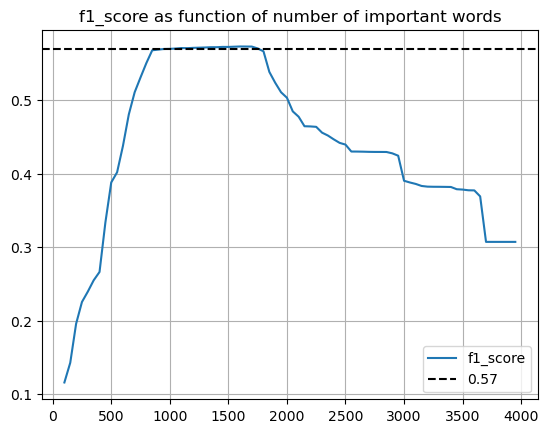

In [242]:
plt.plot(number_of_words, f1_scores, label = 'f1_score')
plt.grid()
plt.axhline(0.57, linestyle = '--', label = '0.57', color = 'black')
plt.legend()
plt.title('f1_score as function of number of important words')
plt.show()

### Making submission

In [ ]:
sentences, _, _ = custom_utils.gather_dataset("test", combine = True)

In [ ]:
def label_phrases_with_keywords(input_dict, important_words):
    output_dict = {}

    for key, phrases in input_dict.items():
        labels = []
        for phrase in phrases:
            # Split the phrase into words
            words = phrase.split()

            # Check if any word in the phrase is in the important words list
            if any(word.strip('.,') in important_words for word in words):
                labels.append(1)
            else:
                labels.append(0)

        output_dict[key] = labels

    return output_dict

# # Example usage
# input_dict = {'TS3003d': ['PM: So <disfmarker>', 'PM: Hello . <vocalsound>', 'ME: Good afternoon .']}
# important_words = ['Good']

# result_dict = label_phrases_with_keywords(input_dict, important_words)
# print(result_dict)


In [ ]:
submit = label_phrases_with_keywords(sentences, important_words)

In [ ]:
json.dump(submit, open('frequency_model.json', 'w'))